In [1]:
#General imports
import numpy as np
import matplotlib.pyplot as plt

#FINESSE specific imports
import finesse
import finesse.components as fc
import finesse.analysis.actions as fac
import finesse.detectors as fd

#Imports for silly plotting
try:
    import wesanderson   #color palettes from wes anderson movies
    from cycler import cycler #matplotlib cycler
    colors = wesanderson.film_palette('darjeeling') + wesanderson.film_palette('rushmore')
    default_cycler = (cycler(color=colors) +
                  cycler(linestyle=['-',(0, (1, 1)),(0, (5, 1)),(5, (10, 3)),(0, (5, 10)),        
                                    (0, (5, 5)),(0, (1, 5)),(0, (3, 10, 1, 10)),(0, (3, 5, 1, 5)),
                                    (0, (3, 1, 1, 1)),])) #parameterized linestyles. do not ask.
    plt.rc('axes', prop_cycle=default_cycler)
    plt.rc('font', **{'family': 'monospace'})
except ImportError as e:
    pass  # don't have libraries installed                                      


# Contents
* [Introduction](#zeroth-bullet)
* [Syntax Reference](#first-bullet) 
* [Building the Model](#second-bullet) 
    * [Tracing the Cavity](#third-bullet) 
* [Imperfect Mode-Matching](#fourth-bullet)

## Introduction <a class="anchor" id="zeroth-bullet"></a>

In this notebook, we'll explore how higher-order Hermite-Gauss modes are implemented in FINESSE, and how you can use them in your models to study complex optical interferometers.

First off, why would we want to do this? As we saw in the previous session the plane-waves model was already quite powerful

## Syntax Reference <a class="anchor" id="first-bullet"></a>

1) **link** <a class="anchor" id="link"></a> - Generates spaces of arbitrary length between components. Names of spaces are autogenerated. 

        model.link(component: str, length: float, verbose = False: bool)

    To link multiple components, specify components in order with lengths between. For example, to link a laser to a mirror with 1m between them, you could use:

        model.link(laser, 1, mirror, verbose = True)

    The verbose flag simply means that FINESSE will print out a list of the connections it has made.

2) **mismatches_table()** <a class="anchor" id="mmtab"></a> - Displays mismatches present in model as a table. 

        model.mismatches_table(ignore_AR = True: bool, numfmt='{:.4f}': str)
    
    The mismatch between two beam parameters in FINESSE is defined as:
    $
       M = \frac{|q_1 - q_2|^2}{|q_1 - q^{*}_2|^2}.
    $
    The ignore_AR flag specifies whether FINESSE should ignore reflection mismatch for surfaces with R=0. numfmt arg allows you to specify how you want the number printed, following standard python formatting options. The default is a floating point number rounded to 4 decimal places.
3) **gauss** <a class="anchor" id="gauss"></a> - Manually specify a beam parameter at a certain node.

4) **modes** <a class="anchor" id="modes"></a> - Specify which TEM modes FINESSE should include in simulation.

        model.modes(modes = None: list or str, maxtem = None: int, include = None: list, remove = None: list)

    maxtem arg should be an integer corresponding to the maximum mode order to be included in the model. The modes/include/remove args can be iterables which can be unpacked into two integer values (one for each mode index), i.e if you wanted to model using only the [0,0], [2,0], and [0,2] modes, you could use

        model.modes(modes = [[0,0],[2,0],[0,2]])

    The modes arg can additionally be a str, either 'even'/'odd' or 'x'/'y' to finetune which modes you want to model with. Check your understanding of this function by determining which modes would be included in the model if the command:

        model.modes(modes = 'even', maxtem = 3, remove = [[0,0],[1,1]])
    was used.
        

## Building the Model <a class="anchor" id="second-bullet"></a>

We'll start by rebuilding our simple Fabry-Perot cavity, first defining our model:

And adding some components. A quick doodle of the cavity (below) shows that we'll need: a laser, two mirrors, and spaces to connect them.

In [2]:
# Cavity 
#                          /--\                   /--\
#                  M1.p1.i |  | M1.p2.o   M2.p1.i |  | M2.p2.o
#        .-------.     --->|  |--->           --->|  |--->
#        |Laser  |--->     |M1|                   |M2|
#        `-------'     <---|  |<---           <---|  |<---
#                  M1.p1.o |  | M1.p2.i   M2.p1.o |  | M2.p2.i
#                          \--/                   \--/


In [3]:
model = finesse.Model()

### Sources ###
laser = model.add(fc.Laser("Laser", P = 1, phase = 0))

### Mirrors ###
m1 = model.add(fc.Mirror("M1", R = 0.9, T = 0.1, Rc = -2))
m2 = model.add(fc.Mirror("M2", R = 0.9, T = 0.1, Rc = 2))



In the previous session, we verbosely defined individual space components. This will certainly do it, but if you don't really care about what the spaces are called (which you often won't) then you can have FINESSE automatically populate your model with spaces, which is faster and less verbose (and prettier imo). There are a few commands to do this, but I'll use [**link**](#link).

In [4]:
### Spaces ###
model.link(laser,1,m1,1,m2, verbose = True)

Connecting Laser to M1
Selecting port <Port Laser.p1 Type=NodeType.OPTICAL @ 0x7482ec2fe620> for <'Laser' @ 0x7482ec2ff0a0 (Laser)>
Selecting port <Port M1.p1 Type=NodeType.OPTICAL @ 0x7482ec2fe110> for <'M1' @ 0x7482ec2fe0e0 (Mirror)>
Connecting M1 to M2
Selecting port <Port M1.p2 Type=NodeType.OPTICAL @ 0x7482741b7460> for <'M1' @ 0x7482ec2fe0e0 (Mirror)>
Selecting port <Port M2.p1 Type=NodeType.OPTICAL @ 0x7482ec2fc130> for <'M2' @ 0x7482ec2fdf30 (Mirror)>


In [5]:
#Finally, we define our cavity, and add some power detectors

### Cavity ###
cav = model.add(fc.Cavity("cav", m1.p2.o, m2.p1.o)) 

### Detectors ###
trans = model.add(fd.PowerDetector("Trans", m2.p2.o))
refl = model.add(fd.PowerDetector("Refl", m1.p1.o))
circ = model.add(fd.PowerDetector("Circ", m2.p1.o))

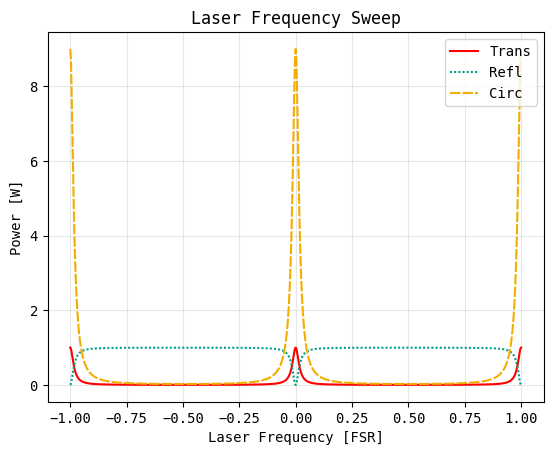

In [6]:
# Just to check, let's run a quick simulation sweeping over the laser frequency. 

sol = model.run(fac.Xaxis(laser.f,"lin",-cav.FSR,cav.FSR,1000))

x1 = sol.x1/cav.FSR
plt.figure()
plt.plot(x1,sol["Trans"],label='Trans'),plt.plot(x1,sol["Refl"],label='Refl'),plt.plot(x1,sol["Circ"],label='Circ')
plt.grid(alpha=0.3), plt.ylabel('Power [W]'), plt.xlabel('Laser Frequency [FSR]'), plt.title('Laser Frequency Sweep')
plt.legend(fontsize=10,loc='upper right');

## Tracing the Cavity <a class="anchor" id="third-bullet"></a>

In [7]:
prop_cav = model.propagate_beam(from_node = m1.p2.o, to_node = m2.p1.i) #Beam propagation through our cavity

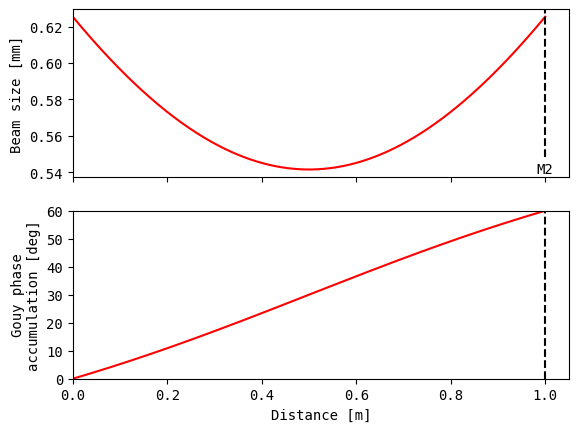

In [8]:
prop_cav.plot();

In [9]:
# Alternatively, we can display this information as a table
prop_cav.table()

,z,w0,zr,w,RoC,S,Acc. Gouy,q
M1.p2.o,0 m,541.58 um,866.03 mm,625.36 um,-2 m,-500 mD,0°,-0.500 + 0.866j
M2.p1.i,1 m,541.58 um,866.03 mm,625.36 um,2 m,500 mD,60°,0.500 + 0.866j


In [10]:
# Now, we can look at the cavity eigenmode and round-trip gouy phase accumulation
print("Cavity Beam Param: ",cav.q[0])
print("Cavity Round-Trip Gouy Phase (x,y): ",cav.gouy)

Cavity Beam Param:  BeamParam(w0=541.58 um, z=-500 mm, w=625.36 um, Rc=-2 m)
Cavity Round-Trip Gouy Phase (x,y):  [120. 120.]


## Imperfect Mode-Matching <a class="anchor" id="fourth-bullet"></a>



Without a beam parameter specified at some node FINESSE will simply trace the eigenmode of the cavity throughout the model. Since we aren't yet specifying any beam parameters, our model will be perfectly mode-matched, which we can check using the method [**mismatches_table**](#mmtab).

In [11]:
print(model.mismatches_table()) #Empty table means no mismatches present.

┌──────────╥──────────────┬──────────────┐
│ Coupling ║ Mismatch (x) │ Mismatch (y) │
└──────────╨──────────────┴──────────────┘



Now, say we had this cavity in the lab and we wanted to mode-match a beam into it. We go off to JaMMt and plug away until we find a mode-matching solution. Once we do, we steal the necessary lenses from a neighboring lab, put them on the table, and, oh no! Our mode-matching solution is off! We wanted a beam radius of 541.58 $\mu m$ 500mm into the cavity, but instead our solution gave us a 558.36 $\mu m$ beam 300mm into the cavity. How can we model this in FINESSE? 

One possible way is using the [**gauss**](#gauss) command, which lets you specify the beam parameter at any node in your model:

In [12]:
gauss_bp = model.add(fc.Gauss("gauss", node = m1.p1.i, w0 = 558.36/1e6, z = -300/1e3))

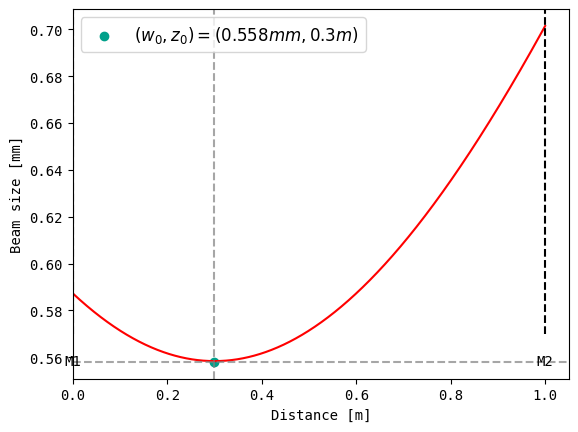

In [13]:
#By propagating the beam like we did earlier, we can verify that our gauss command is working.
#We do see a waist 300mm inside the cavity, with the proper waist size
prop_cav_mismatch = model.propagate_beam(from_node = m1.p1.i, to_node = m2.p1.i)
prop_cav_mismatch.plot_beamsizes(); #plot only beam size, we just want to make sure the waist is in the right place
plt.axvline(0.3,0,1,color='grey',linestyle='dashed',alpha=0.7), plt.axhline(0.558,0,1,color='grey',linestyle='dashed',alpha=0.7)
plt.scatter(0.3,0.558,color=colors[1],label=r'$(w_0,z_0) = (0.558mm, 0.3m)$')
plt.legend(fontsize=12)

We'll also have to specify which TEM modes we want FINESSE to include in any simulations. This is done using the [**modes**](#modes) command:

In [14]:
model.modes(maxtem=3) #use all modes up to order 3

In [15]:
#Now we can check for mismatches again
print(model.mismatches_table())

┌────────────────────╥──────────────┬──────────────┐
│      Coupling      ║ Mismatch (x) │ Mismatch (y) │
╞════════════════════╬══════════════╪══════════════╡
│ M1.p1.i -> M1.p2.o ║       0.0133 │       0.0133 │
├────────────────────╫──────────────┼──────────────┤
│ M1.p1.i -> M1.p1.o ║       0.0325 │       0.0325 │
├────────────────────╫──────────────┼──────────────┤
│ M1.p2.i -> M1.p1.o ║       0.0133 │       0.0133 │
└────────────────────╨──────────────┴──────────────┘



Let's see what the transmitted power looks like now that we have imperfect mode-matching. I'll use amplitude detectors to detect the light-field amplitudes of particular TEM modes. In the case of imperfect mode-matching, we expect coupling into modes of order: $\space$ $m+n = 2$.

In [16]:
ad20 = model.add(fd.AmplitudeDetector("ad20", m2.p2.o, f = 0, n = 2, m = 0))
ad02 = model.add(fd.AmplitudeDetector("ad02", m2.p2.o, f = 0, n = 0, m = 2))
ad11 = model.add(fd.AmplitudeDetector("ad11", m2.p2.o, f = 0, n = 1, m = 1))

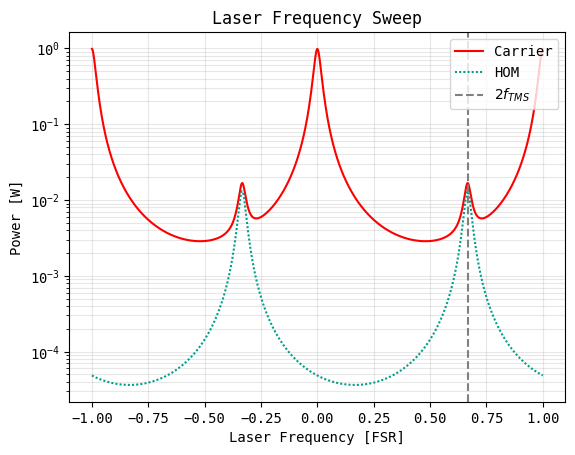

In [17]:
#Now, what if we again swept over the laser frequency and plotted the transmitted power

mismatch_sol = model.run(fac.Xaxis(laser.f,"lin",-cav.FSR,cav.FSR,1000))

#We can determine the total power in the m+n = 2 mode order by summing (in quadrature) the contributions of each
#individual mode

power_in_HOM = np.abs(mismatch_sol["ad20"])**2 + np.abs(mismatch_sol["ad02"])**2 + np.abs(mismatch_sol["ad11"])**2 

x1 = mismatch_sol.x1/cav.FSR
plt.figure()
plt.semilogy(x1,mismatch_sol["Trans"],label='Carrier'), plt.semilogy(x1,power_in_HOM,label=r'HOM')
plt.grid(alpha=0.3,which='both'), plt.ylabel('Power [W]'), plt.xlabel('Laser Frequency [FSR]'), plt.title('Laser Frequency Sweep')
plt.axvline(2*cav.mode_separation[0]/cav.FSR,0,1,label=r'$2f_{TMS}$',color='grey',linestyle='dashed');
plt.legend(fontsize=10,loc='upper right');